Author: Kaushik Raghupathruni

In [ ]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image, ImageEnhance
from skimage.feature import hog
import cv2
import xml.etree.ElementTree as ET
from svgpathtools import parse_path
from collections import defaultdict
from tqdm import tqdm

Dataset Analysis

In [35]:
# Paths
ROOT = Path("dataset")
PAGES_DIR = ROOT / "images"
SVG_DIR = ROOT / "locations"
INDEX_TSV = ROOT / "transcription.tsv"
KEYWORDS_TSV = ROOT / "keywords.tsv"
DEST_DIR = ROOT / "words"
DEST_DIR.mkdir(parents=True, exist_ok=True)
TRAIN_PATH = ROOT / "train.tsv"
VALIDATION_PATH = ROOT / "validation.tsv"

In [36]:
# Parameters
RESIZE_HEIGHT = 64
DTW_BAND_RATIO = 0.25

In [ ]:
# Load splits
train_pages = set(line.strip() for line in TRAIN_PATH.open())
val_pages = set(line.strip() for line in VALIDATION_PATH.open())

def clean_word(word):
    """Cleans word by removing hyphens but keeping special tokens"""
    # Split by hyphens and keep all parts (including s_* tokens)
    parts = word.split('-')
    # Join all parts together (removes hyphens but keeps special tokens)
    cleaned = ''.join(parts)
    return cleaned.lower()

# Load keywords (after cleaning)
keywords = set()
with KEYWORDS_TSV.open() as f:
    for line in f:
        original_keyword = line.strip()
        cleaned_keyword = clean_word(original_keyword)
        if cleaned_keyword:  # Skip empty strings
            keywords.add(cleaned_keyword)

# Load transcription index
index = []
with INDEX_TSV.open() as f:
    for locator, word in csv.reader(f, delimiter="\t"):
        cleaned = clean_word(word)
        if cleaned in keywords:
            index.append({
                'id': locator,
                'keyword': cleaned 
            })

Loaded 35 unique keywords
Sample keywords: ['men', 'wanting', 'greatly', 'day', 'careful', 'order', 's_gw', 'virginia', 'twelve', 's_etcs_pt', 'orders', 'letters', 'instructionss_pt', 'left', 'regiment', 'colonel', 'officers', 'wanted', 'send', 'john', 'things', 'recruits', 'captain', 'mrs_pt', 'robert', 'ordered', 'cumberland', 'receive', 'opportunity', 'place', 'hundred', 'major', 'de', 'made', 'fort']


[{'id': '270-01-03', 'keyword': 'orders'},
 {'id': '270-01-05', 'keyword': 'instructionss_pt'},
 {'id': '270-04-02', 'keyword': 'orders'},
 {'id': '270-04-08', 'keyword': 'send'},
 {'id': '270-08-01', 'keyword': 'twelve'},
 {'id': '270-08-02', 'keyword': 'hundred'},
 {'id': '270-09-01', 'keyword': 'captain'},
 {'id': '270-10-09', 'keyword': 'captain'},
 {'id': '270-12-03', 'keyword': 's_gw'},
 {'id': '270-16-02', 'keyword': 'officers'},
 {'id': '270-17-02', 'keyword': 'fort'},
 {'id': '270-17-03', 'keyword': 'cumberland'},
 {'id': '270-17-05', 'keyword': 'colonel'},
 {'id': '270-21-05', 'keyword': 'place'},
 {'id': '270-24-08', 'keyword': 'de'},
 {'id': '270-25-07', 'keyword': 'receive'},
 {'id': '270-26-02', 'keyword': 'instructionss_pt'},
 {'id': '270-28-02', 'keyword': 'men'},
 {'id': '270-33-04', 'keyword': 'made'},
 {'id': '270-33-08', 'keyword': 'de'},
 {'id': '271-02-02', 'keyword': 'orders'},
 {'id': '271-02-04', 'keyword': 'instructionss_pt'},
 {'id': '271-04-07', 'keyword': '

In [32]:
# Function for SVG bbox extraction
def bbox_from_svg(svg_path: Path, locator):
    target_id = locator
    elem = ET.parse(str(svg_path)).find(f".//*[@id='{target_id}']")
    if elem is None:
        raise ValueError(f"id {target_id} not found in {svg_path.name}")
    path = parse_path(elem.get("d"))
    xmin, xmax, ymin, ymax = path.bbox()
    return xmin, ymin, xmax - xmin, ymax - ymin

# Function to convert SVG coordinates to pixel coordinates
def svg_to_pixel_coords(svg_path: Path, jpg_path: Path, xywh):
    svg_width  = float(ET.parse(str(svg_path)).getroot().get("width").rstrip("px"))
    svg_height = float(ET.parse(str(svg_path)).getroot().get("height").rstrip("px"))
    img = Image.open(jpg_path)
    img_w, img_h = img.size
    scale_x = img_w / svg_width
    scale_y = img_h / svg_height
    x, y, w, h = xywh
    return int(x*scale_x), int(y*scale_y), int(w*scale_x), int(h*scale_y)

In [53]:
def preprocess_word_image(img):
    # Convert to grayscale if needed
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Adaptive thresholding
    bw = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                             cv2.THRESH_BINARY_INV, 21, 10)
    
    # Morphological operations to clean up
    kernel = np.ones((2,2), np.uint8)
    bw = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, kernel)
    
    return bw

In [58]:

def z_normalize_features(seq):
    scaler = StandardScaler()
    return scaler.fit_transform(seq)

def pad_or_trim_sequence(seq, target_len=100):
    if len(seq) > target_len:
        return seq[:target_len]
    elif len(seq) < target_len:
        pad = np.tile(seq[-1], (target_len - len(seq), 1))
        return np.vstack([seq, pad])
    return seq


In [ ]:
# Sliding Window Feature Extraction
def extract_window_features(bw, window_width=1, step=1):
    h, w = bw.shape
    features = []
    for x in range(0, w - window_width + 1, step):
        window = bw[:, x:x + window_width]
        lc = np.argmax(window.any(axis=1))
        uc = h - np.argmax(window[::-1].any(axis=1))
        transitions = np.sum(np.abs(np.diff(window, axis=0)) > 0)
        black_frac = np.mean(window)
        black_between = np.mean(window[lc:uc + 1]) if lc < uc else 0
        grad_lc = np.argmax(window[:, 0]) - np.argmax(window[:, 0])
        grad_uc = (h - np.argmax(window[::-1, 0])) - (h - np.argmax(window[::-1, 0]))
        features.append([lc, uc, transitions, black_frac, black_between, grad_lc, grad_uc])
    return np.array(features)

# Extract HOG features
def extract_hog_features(bw, resize=(64, 64)):
    resized = cv2.resize(bw, resize, interpolation=cv2.INTER_AREA)
    features = hog(resized, orientations=8, pixels_per_cell=(8, 8),
                   cells_per_block=(1, 1), visualize=False, feature_vector=True)
    return features.reshape(-1, 8)  # Treat each block as a time step


In [56]:
# DTW with Sakoe-Chiba Band
def dtw_distance_with_sakoe_chiba(s1, s2, w):
    n, m = len(s1), len(s2)
    w = max(w, abs(n - m))
    dtw = np.full((n + 1, m + 1), np.inf)
    dtw[0, 0] = 0
    for i in range(1, n + 1):
        for j in range(max(1, i - w), min(m + 1, i + w + 1)):
            cost = np.linalg.norm(s1[i - 1] - s2[j - 1])
            dtw[i, j] = cost + min(dtw[i - 1, j], dtw[i, j - 1], dtw[i - 1, j - 1])
    return dtw[n, m] / (n+m) # normalise distance

In [57]:
for rec in tqdm(index):
    locator = rec["id"]
    word = rec["keyword"]
    page = locator.split("-", 1)[0]
    svg_path = SVG_DIR / f"{page}.svg"
    jpg_path = PAGES_DIR / f"{page}.jpg"

    try:
        xywh_svg = bbox_from_svg(svg_path, locator)
        x, y, w, h = svg_to_pixel_coords(svg_path, jpg_path, xywh_svg)
        img = Image.open(jpg_path).convert("L")
        crop = img.crop((x, y, x+w, y+h))

        # Improve constrast
        crop = ImageEnhance.Contrast(crop).enhance(2.0)

        dest_dir = DEST_DIR / word
        dest_dir.mkdir(exist_ok=True)
        out_path = dest_dir / f"{locator}.png"
        crop.save(out_path)
    except Exception as e:
        print(f"Failed {locator}: {e}")

100%|██████████| 246/246 [00:03<00:00, 63.39it/s]


In [ ]:
# Feature Extraction
val_data = []
for word_dir in DEST_DIR.iterdir():
    label = word_dir.name
    for img_path in word_dir.glob("*.png"):
        locator = img_path.stem
        page_id = locator.split("-", 1)[0]
        if page_id not in val_pages:
            continue
        try:
            img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
            bw = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                       cv2.THRESH_BINARY_INV, 15, 11)
            bw = cv2.resize(bw, (100, 100), interpolation=cv2.INTER_NEAREST)
            win_feats = extract_window_features(bw)
            hog_feats = extract_hog_features(bw)
            min_len = min(len(win_feats), len(hog_feats))
            seq = np.concatenate([win_feats[:min_len], hog_feats[:min_len]], axis=1)
            seq = z_normalize_features(seq)
            seq = pad_or_trim_sequence(seq)
            val_data.append((img_path.name, label, seq))
        except Exception as e:
            print(f"Error processing {img_path}: {e}")

In [ ]:
# Filter Infrequent Labels
from collections import Counter


label_counts = Counter(label for _, label, _ in val_data)
val_data = [(f, l, s) for f, l, s in val_data if label_counts[l] >= 5]

In [ ]:
# DTW Matching

results = {}
for query_fname, query_label, query_seq in tqdm(val_data, desc="DTW Matching"):
    distances = []
    for fname, label, seq in val_data:
        if fname == query_fname:
            continue
        # Optional prefilter: skip wildly different lengths
        if abs(len(query_seq) - len(seq)) > 20:
            continue
        dist = dtw_distance_with_sakoe_chiba(query_seq, seq, w=10)
        distances.append((fname, label, dist))
    distances.sort(key=lambda x: x[2])
    results[query_fname] = {
        "query_label": query_label,
        "matches": distances
    }

DTW Matching: 100%|██████████| 22/22 [00:02<00:00, 10.98it/s]


In [ ]:
import random

# Evaluation
def evaluate_full(results, top_k=10, fraction=1.0, seed=42):
    random.seed(seed)
    keys = list(results.keys())
    
    if fraction < 1.0:
        sample_size = max(1, int(len(keys) * fraction))
        keys = random.sample(keys, sample_size)

    metrics = {}
    for query_fname in keys:
        result = results[query_fname]
        query_label = result["query_label"]
        matches = result["matches"]

        tp = sum(1 for _, label, _ in matches[:top_k] if label == query_label)
        fp = top_k - tp
        fn = sum(1 for _, label, _ in matches if label == query_label) - tp

        precision = tp / (tp + fp + 1e-10)
        recall = tp / (tp + fn + 1e-10)
        f1 = 2 * precision * recall / (precision + recall + 1e-10)

        metrics[query_fname] = {
            "query_label": query_label,
            "precision": precision,
            "recall": recall,
            "f1": f1
        }

    return metrics

# Run evaluation
metrics = evaluate_full(results, top_k=10, fraction=1.0)

# Sample printout
print("\nSample query evaluation (Top-10):")
for i, (qname, m) in enumerate(metrics.items()):
    print(f"{qname:25s} | Label: {m['query_label']:10s} | P: {m['precision']:.2f}  R: {m['recall']:.2f}  F1: {m['f1']:.2f}")
    if i >= 9:
        break

avg_p = np.mean([m["precision"] for m in metrics.values()])
avg_r = np.mean([m["recall"] for m in metrics.values()])
avg_f1 = np.mean([m["f1"] for m in metrics.values()])
print(f"\nAverage Precision: {avg_p:.3f}, Recall: {avg_r:.3f}, F1-score: {avg_f1:.3f}")


Sample query evaluation (Top-10):
304-12-03.png             | Label: captain    | P: 0.10  R: 0.25  F1: 0.14
301-07-06.png             | Label: captain    | P: 0.30  R: 0.75  F1: 0.43
303-14-01.png             | Label: captain    | P: 0.30  R: 0.75  F1: 0.43
303-16-06.png             | Label: captain    | P: 0.20  R: 0.50  F1: 0.29
303-16-09.png             | Label: captain    | P: 0.10  R: 0.25  F1: 0.14
303-02-01.png             | Label: letters    | P: 0.50  R: 1.00  F1: 0.67
301-03-01.png             | Label: letters    | P: 0.40  R: 0.80  F1: 0.53
300-21-04.png             | Label: letters    | P: 0.30  R: 0.60  F1: 0.40
304-01-02.png             | Label: letters    | P: 0.40  R: 0.80  F1: 0.53
302-01-02.png             | Label: letters    | P: 0.30  R: 0.60  F1: 0.40

Average Precision: 0.332, Recall: 0.730, F1-score: 0.455


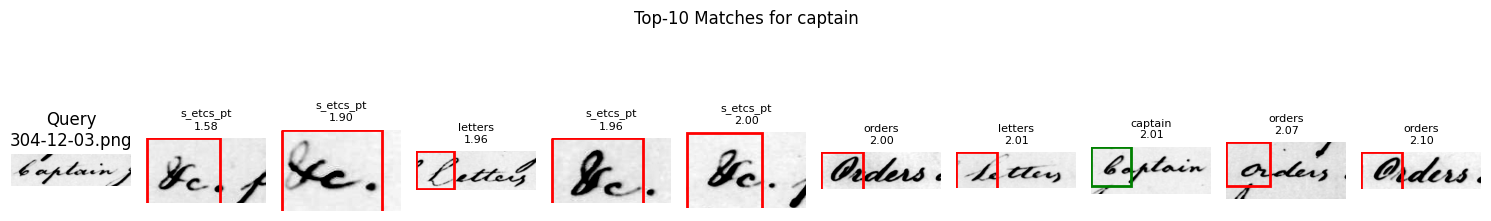

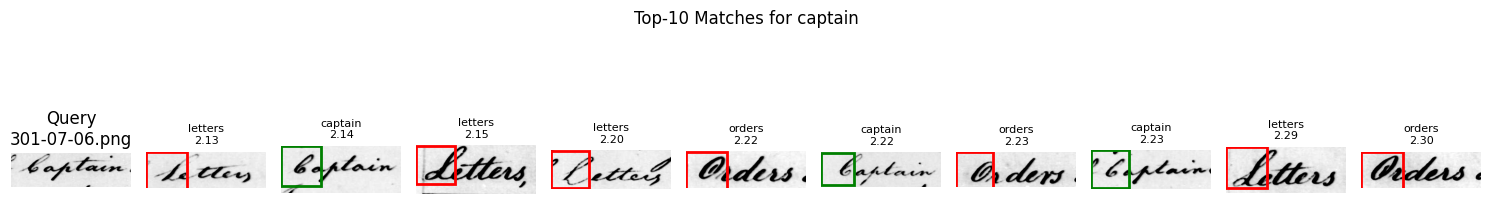

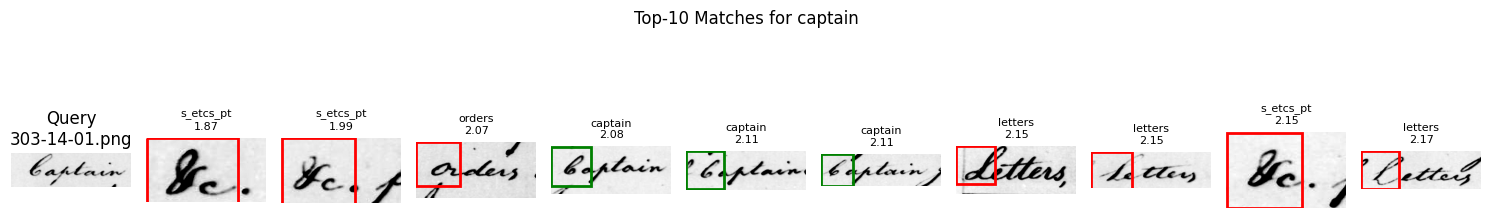

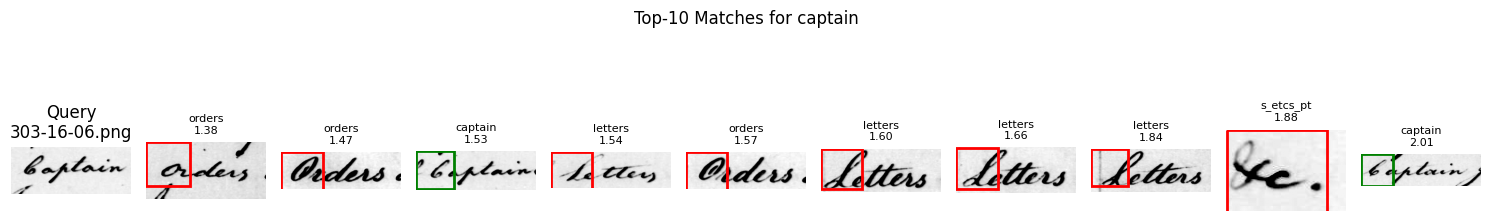

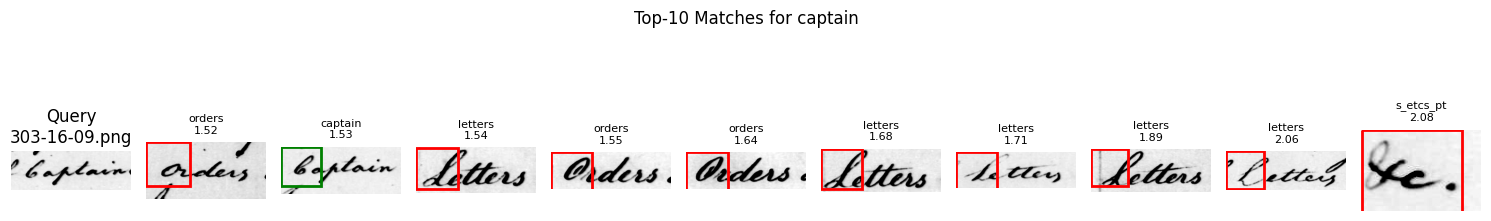

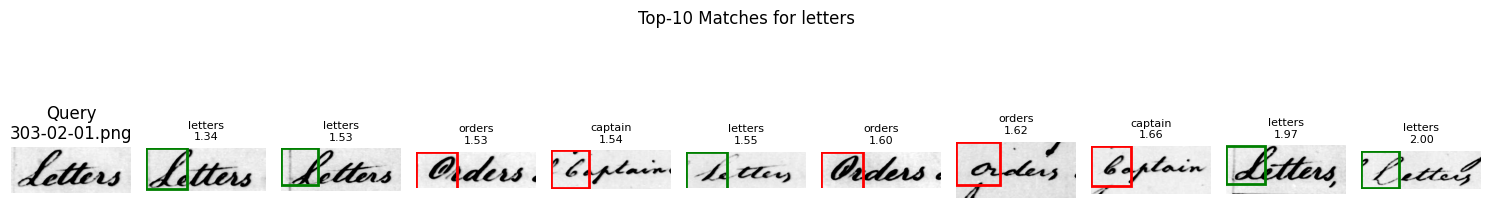

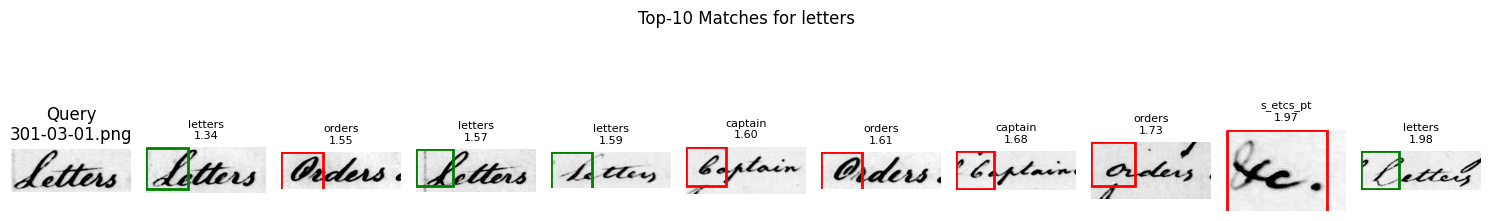

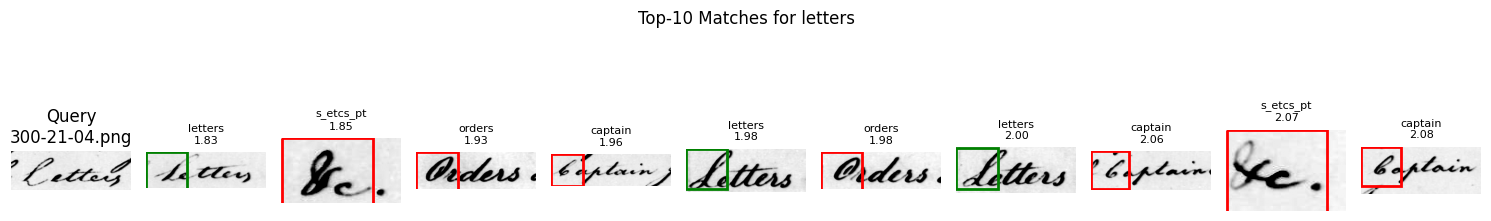

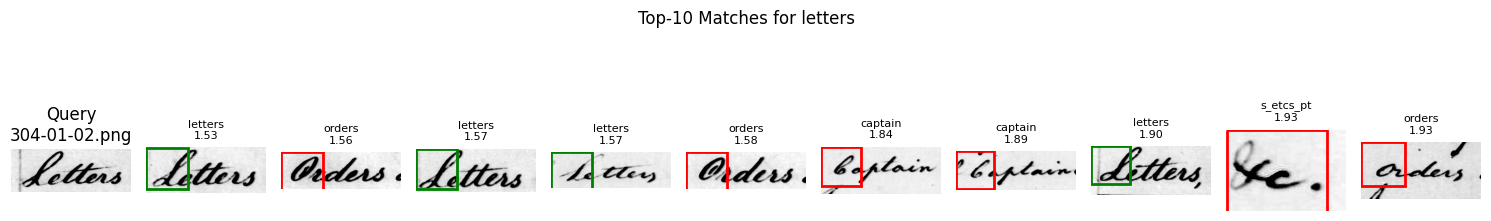

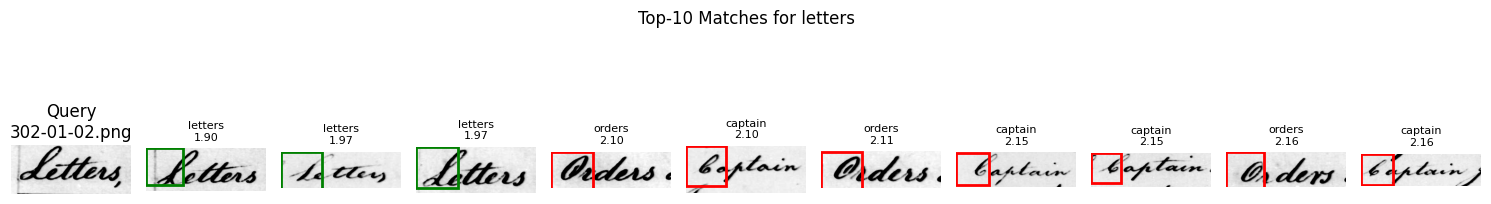

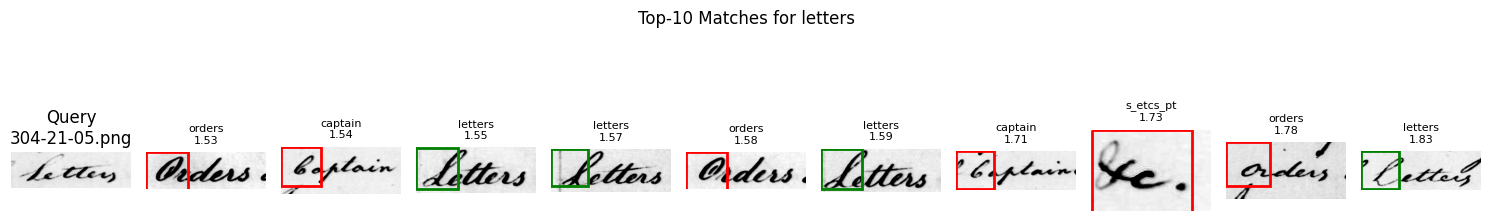

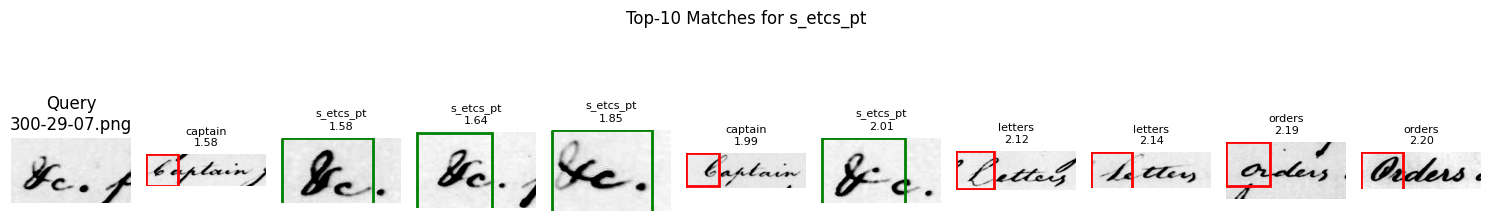

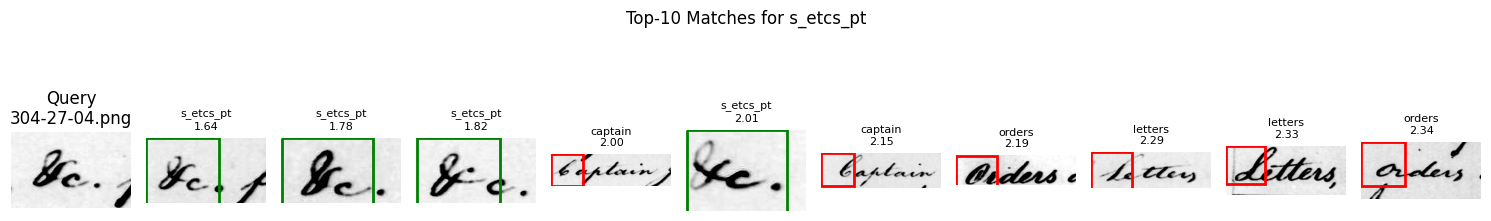

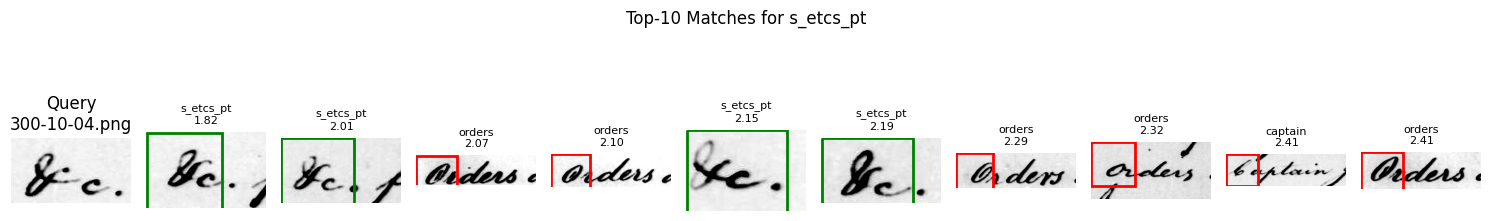

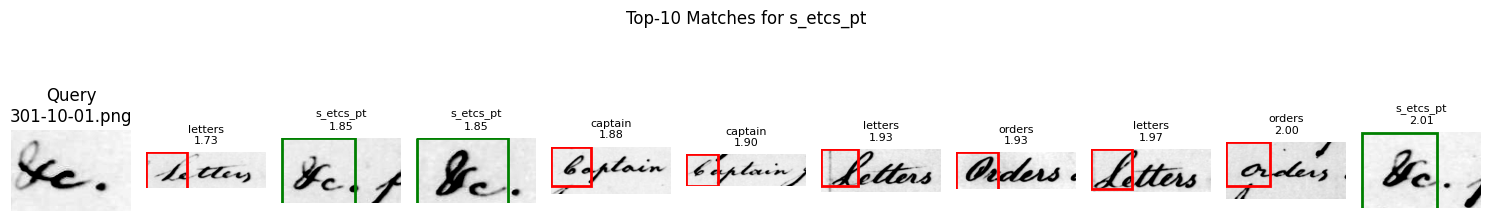

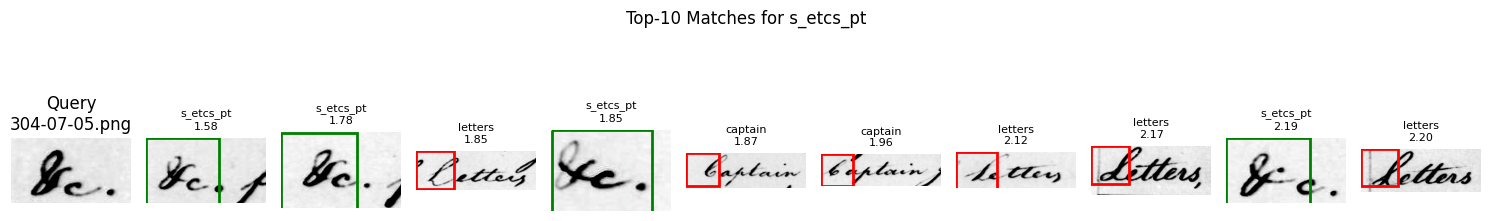

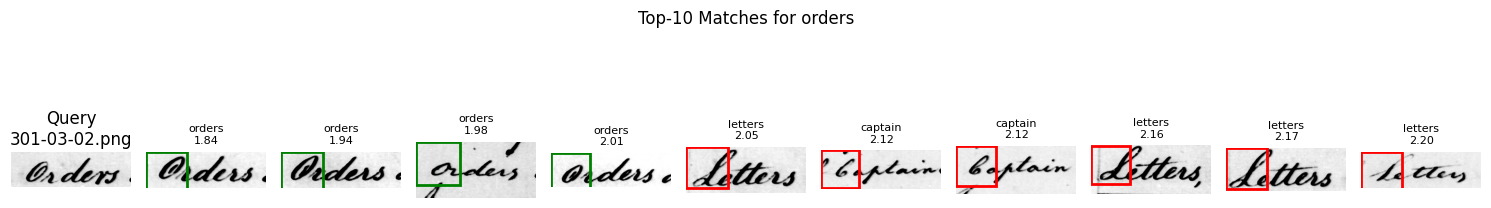

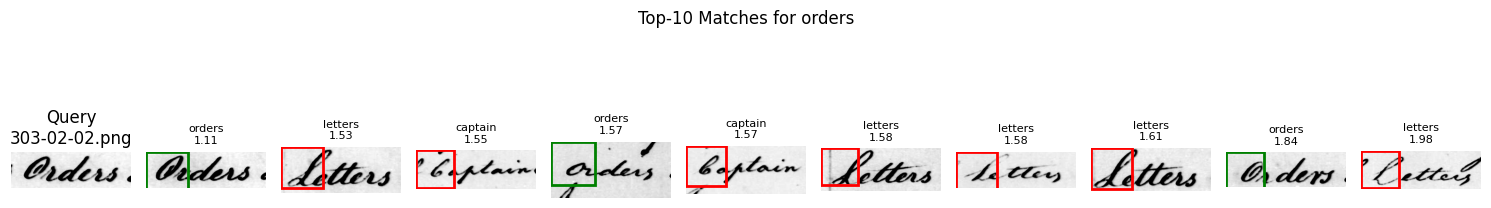

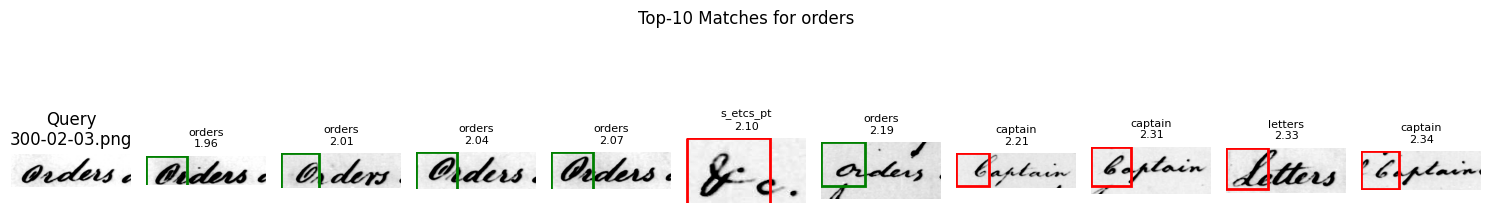

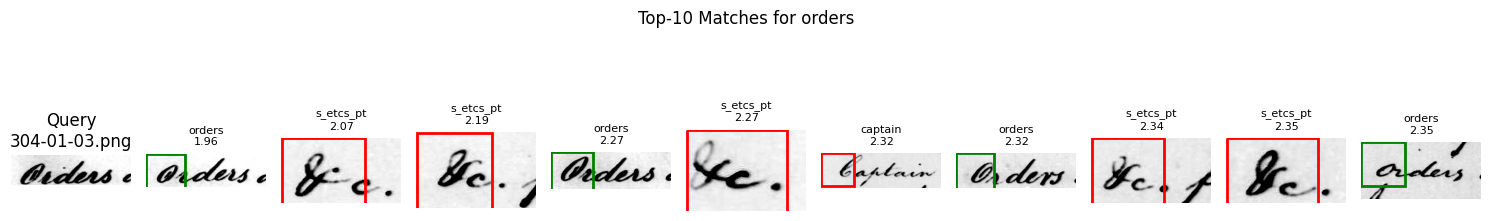

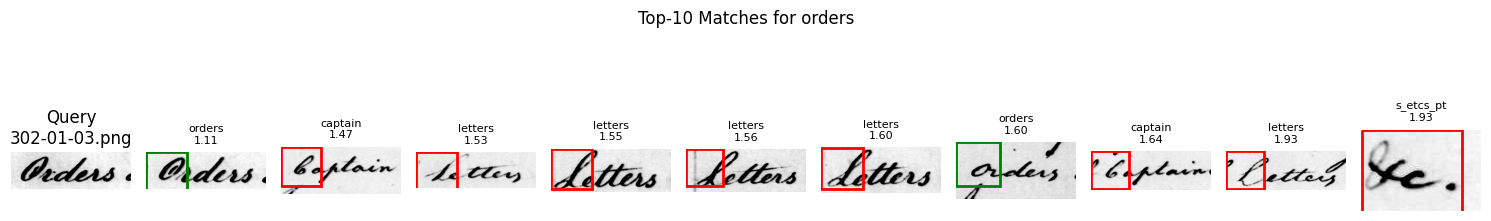

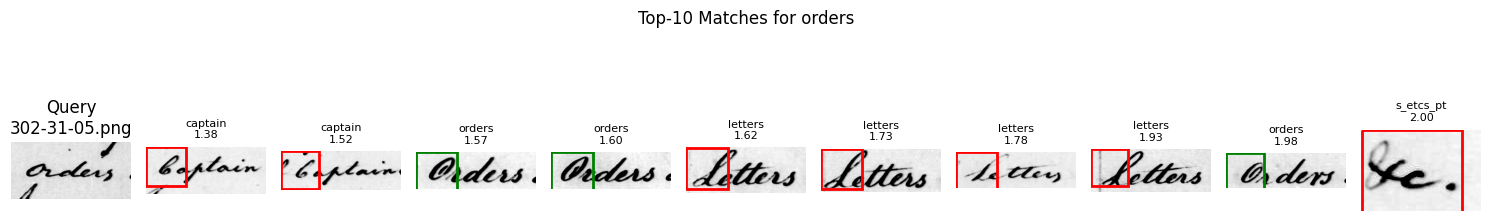

In [64]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def show_top_matches(results, num_queries=5, top_k=10):
    shown = 0
    for query_fname, result in results.items():
        query_label = result["query_label"]
        query_img = cv2.imread(str(DEST_DIR / query_label / query_fname), cv2.IMREAD_GRAYSCALE)
        if query_img is None:
            continue

        matches = result["matches"][:top_k]
        fig, axes = plt.subplots(1, top_k + 1, figsize=(15, 3))
        axes[0].imshow(query_img, cmap='gray')
        axes[0].set_title(f"Query\n{query_fname}")
        axes[0].axis('off')

        for i, (fname, label, dist) in enumerate(matches):
            match_path = DEST_DIR / label / fname
            match_img = cv2.imread(str(match_path), cv2.IMREAD_GRAYSCALE)
            axes[i + 1].imshow(match_img, cmap='gray')
            axes[i + 1].set_title(f"{label}\n{dist:.2f}", fontsize=8)
            axes[i + 1].axis('off')

            # Border color
            rect = patches.Rectangle((0, 0), 99, 99, linewidth=2,
                                     edgecolor='g' if label == query_label else 'r',
                                     facecolor='none')
            axes[i + 1].add_patch(rect)

        plt.suptitle(f"Top-{top_k} Matches for {query_label}", fontsize=12)
        plt.tight_layout()
        plt.show()

        shown += 1
        if shown >= num_queries:
            break

# Call the visualizer
show_top_matches(results, num_queries=25, top_k=10)